# Controlling the variance of PANDA networks

Kalyan Palepu<sup>1</sup>, Marouen Ben Guebila<sup>2</sup>

<sup>1</sup> Harvard College, Harvard University, Boston, MA, USA.

<sup>2</sup> Harvard School of Public Health, Harvard University, Boston, MA, USA.

## Motivation
Passing Attributes between Networks for Data Assimilation (PANDA)<sup>1</sup> allows to infer complete bipartite gene regulatory networks (GRNs) between Transcription Factors (TFs) and their target genes using three input data matrices: TF PPI interaction ($P$), gene coexpression ($C$), TF target motif-based prediction ($W_0$). A common procedure to interpret PANDA GRNs consists of thresholding resulting network ($W$) edges to retain the most important ones and to reduce the network size on memory.

A common misconception consists of assuming that strictly positive edges exist, in other words, zero is a natural threshold of PANDA networks. In reality, PANDA edges are distribued in a biomodal distribution with edges present in $W_0$ are in the first mode and all other edges are in the second.

To illustrate this, let's download a network from GRAND (http://grand.networkmedicine.org) and plot the network edges. First let's load the needed libraries.

In [1]:
import os
import pandas as pd # to read the network
import matplotlib.pyplot as plt # to plot the distribution
import numpy as np # for linear algebra operations
import scipy.stats as st # for the densities of common distributions

In [2]:
os.system('curl -O https://granddb.s3.amazonaws.com/tissues/networks/Adrenal_Gland.csv')
net = pd.read_csv('Adrenal_Gland.csv', index_col=0)

Then, let's plot the distribution of the network edges.

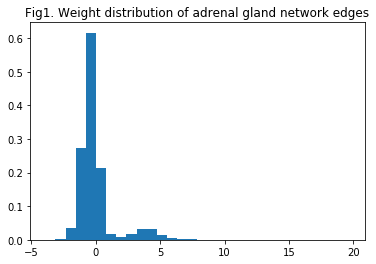

In [3]:
plt.hist(net.values.flatten(), density=1, bins=30);
plt.title('Fig1. Weight distribution of adrenal gland network edges');

We clearly see two modes in the histogram, we also deduce that zero is not a central value in the network. Controlling the distribution of PANDA networks is important because it allows comparing the networks to each other, such as in case versus control settings. The current approach to achieve such control is to produce the networks using the same input data, in particular using the same $W_0$ that exerts a large influence on the reconstruction of the inferred GRN.

However, as motif mappings are refined<sup>2</sup>, $W_0$ can change to include additional TFs, genes, and edges. Comparing PANDA networks in those conditions can be less straightforward. Therefore, controlling the distribution of PANDA network edges in a principled approach could offer an alternative to compare networks that were generated using different input data. In particular, we are interested in comparing edge weights from different networks and make inferences of the type: if $W_{(i,j)}^{disease} > W_{(i,j)}^{control}$ means that there an upregulation of gene $j$ by TF $i$ in disease state.

The suggested approach consists of i) identifying network edge distribution then ii) modeling the edge distribution using a common law. Since the input matrices are standardized prior to PANDA loop, the standard normal distribution seems a good candidate. 

## Modeling network edge distribution
### The distribution of the distance of two random variables

At it is core, PANDA iteratively measures the distance between three sets of inputs after standrdizing them in the first step. The distance considered in the original implementation is a continuous modification of Tanimoto distance. Although, we mentionned that distance is measured between two variables $X$ and $Y$ that follow a standard normal distribution, we will assume the general case where $X \sim\ N(0,a)$ and $Y \sim\ N(0,b)$ respectively.
Let's define the variances $a$ and $b$.

In [4]:
a = 4
b = 2

Then, we will investigate the distribution of the variable $Z \sim\ T(X, Y)$, such as $T(x,y)$ is the modified Tanimoto similarity. We will use the expression from equation 13 in the supplementary data of the PANDA paper<sup>1</sup>. We will simply generate random samples of the nominator, the denominator, and the resulting variable $Z$. 

In [5]:
results = []
nums = []
denoms = []
for i in range(10000):
    n = 1000
    x = np.random.normal(0, np.sqrt(a), n)
    y = np.random.normal(0, np.sqrt(b), n)
    num = np.dot(x, y)
    denom = np.linalg.norm(x - y)
    nums.append(num)
    denoms.append(denom)
    results.append(num / denom)

Assuming that $n$ is the number of samples from the distribution, we can verify that the nominator follows $N(0, \frac{n(a + b)^2}{4})$.

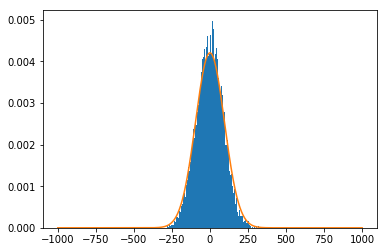

In [6]:
fig, ax = plt.subplots(1, 1)
ax.hist(nums, bins=100, density=True)
x = np.linspace(-1000, 1000, num=1000)
ax.plot(x, st.norm.pdf(x, 0, (a + b) / 2 * np.sqrt(n)));

Although we can't tell much about the denominator, we can check that it follows the square root of a $(a + b) \chi^2(n)$ distribution, which we don't need to develop further to derive the law of the whole expression.

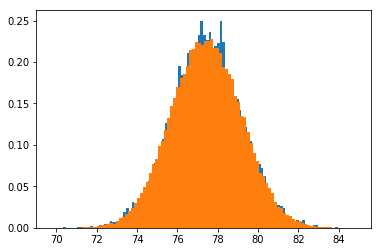

In [7]:
fig, ax = plt.subplots(1, 1)
_ = ax.hist(denoms, bins=100, density=True)
dist = np.sqrt((a + b) * st.chi2.rvs(n, size=100000))
_ = ax.hist(dist, bins=100, density=True)

Finally, the variable $Z$ which is a fraction of the two previous quantities follows a student $t$-distribution of parameter $n$ multiplied by a constant $\frac{\sqrt{(a+b)}}{2}$. $n$ being very large, we can approximate the student distribution by $N(0,1)$, therefore $Z \sim\ N(0,\frac{a+b}{4})$.

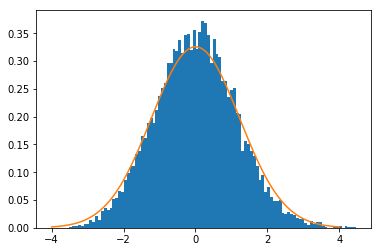

In [8]:
fig, ax = plt.subplots(1, 1)
ax.hist(results, bins=100, density=True)
x = np.linspace(-4, 4, num=10000)
ax.plot(x, st.norm.pdf(x, 0, np.sqrt(a + b) / 2));

### Calculating the variance of the updated $W$
Starting from this point, we will assume that all considered variables are i.i.d.

In the next step of the PANDA algorithm, $W_{i}$, the estimated regulatory netowork in the current step $i$, is computed as a weighted sum of two $Z$-distributed variables, the weights ($respWeight$) are usually set to $\frac{1}{2}$ in the standard implementation of PANDA and can be changed in [optPANDA](https://github.com/netZoo/netZooM/blob/master/tutorials/opt_panda/opt_panda.pdf) for example, therefore $W_{i} \sim\ N(0,\frac{a+b}{8})$.

Next, a learning step is performed using the rate $\alpha$ to infer the updated regulatory network $W_{i+1}$: $W_{i+1} = (1-\alpha)W_{i-1} + \alpha W_{i}$. 
Because we standardize the inputs, we can assume that $a=b=c=1$, therefore, $W_{i-1} \sim\ N(0,1)$ and $W_{i+1} \sim\ N(0,(1-\alpha)^{2} + \frac{\alpha^2}{2})$.

### Calculating the variance of the updated $P$ and $C$
Similarly, updating $P$ and $C$ roughly follows the same steps. First, the distance between two $W_{i+1}$-distributed normal variables of variances $a'$ and $b'$ are computed, therefore they follow $N(0, \frac{a'+b'}{4})$ as previously determined. Second, in contrast to updating $W$, the weighted sum step is skipped. Third, let's assume $P_{i-1} \sim\ N(0,c')$, since we standardize the input, $c'=1$. Finally, let's assume that we controlled the variance of $W$ in the previous step to 1, therefore $a'=b'=1$.
Taken together, after the learning step, $P_{i+1} \sim\ N(0,(1-\alpha)^{2} + \frac{\alpha^2}{2})$.

Using the same approach, $C_{i+1} \sim\ N(0,(1-\alpha)^{2} + \frac{\alpha^2}{2})$, with $C_{i-1} \sim\ N(0,c'')$ and $C_{i}$ is computed as the distance between two $W_{i+1}$-distributed normal variables of variances $a''$ and $b''$ that we assumed equal to 1 since we standrdized the iintermediary quantity $W_i$ and the input $C_{i-1}$.

For a complete description of the steps of the PANDA algorithm, please check the corresponding publication<sup>1</sup> and an implementation in your [favorite language](https://github.com/netZoo/netZooPy/tree/master/netZooPy/panda).

## Controlling the variance of network edge distribution
Knowing the number of steps until converge, we can control the variance of PANDA network in only one step in the end of the algorithm using the previous formulation that integrates unkonwn variances $a$, $b$, $c$, $c'$, and $c''$. However, while this implementation can be the object of future reasearch for the obvious benefit in terms of speed and the ability to standardize any previously generated PANDA network, we will take a step-wise correction approach for the current work.

First, we will assume that $a=b=c=1$, since all the input matrices are standardized.
However, keep in mind that while this assumption can hold for $P$, the PPI network and $C$ the correlation matrix that we can assume normally distributed, $W_0$ is a binary matrix, therefore this assumption can be challenged.

Therefore, $\frac{1}{\sqrt{(1-\alpha)^2 + \frac{\alpha^2}{2}}}W \sim\ N(0,1)$. After correcting the variance of $W$, $a"=b"=a'=b'=1$, therefore $\frac{1}{\sqrt{(1-\alpha)^2 + \frac{\alpha^2}{2}}}P \sim\ N(0, 1)$, and $\frac{1}{\sqrt{(1-\alpha)^2 + \frac{\alpha^2}{2} }}C \sim\ N(0, 1)$.


## Practical considerations
To test the validity of our approach on a real life example, we can download colon cancer<sup></sup> input data from [GRAND](https://grand.networkmedicine.org) and test our hypotheses.

In [9]:
os.system('curl -O https://granddb.s3.amazonaws.com/cancer/colon_cancer/cancer_colon_ppi.txt')
os.system('curl -O https://granddb.s3.amazonaws.com/cancer/colon_cancer/cancer_colon_motif.txt')
os.system('curl -O https://granddb.s3.amazonaws.com/cancer/colon_cancer/cancer_colon_expression_tcga.txt')
ppi_data_cancer       ='cancer_colon_ppi.txt'
motif_data_cancer     ='cancer_colon_motif.txt'
expression_data_cancer='cancer_colon_expression_tcga.txt'
ppi_data_c          = pd.read_csv(ppi_data_cancer,header=0,index_col=0,sep='\t')
motif_data_c        = pd.read_csv(motif_data_cancer,header=0,index_col=0,sep='\t')
expression_data_c   = pd.read_csv(expression_data_cancer,header=0,index_col=0,sep='\t')

Simply plotting the distribution of edge weights of the input matrices shows that while this normality assumption can hold for $C$, $P$ seems lognormally distributed while $W_0$ is a discrete variable.

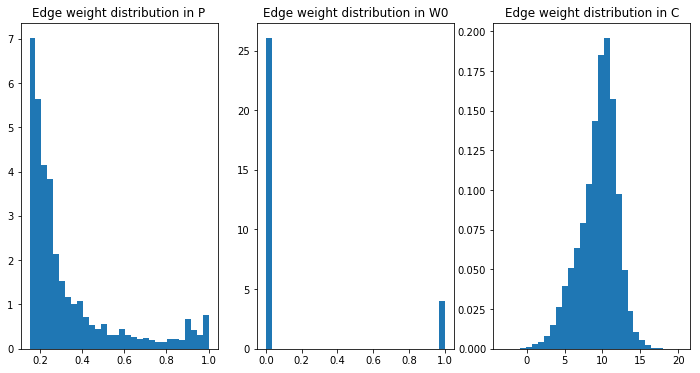

In [10]:
fig, (ax0, ax1, ax2) =  plt.subplots(1, 3, sharey=False, figsize=(12, 6))
ax0.hist(ppi_data_c.iloc[:,1], density=1, bins=30);
ax1.hist(motif_data_c.iloc[:,1], density=1, bins=30);
ax2.hist(expression_data_c.values.flatten(), density=1, bins=30);
ax0.set_title('Edge weight distribution in P');
ax1.set_title('Edge weight distribution in W0');
ax2.set_title('Edge weight distribution in C');

## Future steps and the case for a continuous $W_0$
 
Therefore, to be able to control the variance of the computed regulatory network, the current framework needs to be extended to address the distribution of the modified Tanimoto distance between continuous and discrete variables. 

In addition, a more viable approach consists of computing a continuous $W_{0}$ using for example the distance between the TF motif and the promoter or the transcription start site of the target gene. In this case, the current framework lends itself naturally to a more accurate approximation of the variance of regulatory networks. Such approach would also allow to correct the strong bias of the final network $W$ to $W_0$ (Figure 1), accelerate the convergence of the algorithm, and find a natural stopping threshold without relying on a forced convergence.

## References
1 - Glass, Kimberly, et al. "Passing messages between biological networks to refine predicted interactions." PloS one 8.5 (2013): e64832.

2 - Lambert, Samuel A., et al. "The human transcription factors." Cell 172.4 (2018): 650-665.

3 - Lopes-Ramos, Camila M., et al. "Gene regulatory network analysis identifies sex-linked differences in colon cancer drug metabolism." Cancer research 78.19 (2018): 5538-5547.